# Phase 2: Classification and Generation of EMG -> Hand Gestures with DNN

## DNN

In [ ]:
import torch.nn as nn

# Encoder for DB2 (12 emg channels) to 9D latent space
class EncoderDB2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 9)
        )

    def forward(self, x):
        return self.model(x)

# Encoder for DB1 (10 emg channels) to 9D latent space
class EncoderDB1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 9)
        )

    def forward(self, x):
        return self.model(x)

# Decoder for classification: 9D latent space to 53 gesture classes
class GestureDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 53)
        )

    def forward(self, x):
        return self.model(x)

# Decoder for reconstruction: 9D latent space to 10 emg channels for input reconstruction
class ReconstructionDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.model(x)


## Training for Encoding/Classification/Reconstruction of DB1

Training new models...
Epoch 1/250 - Total Loss: 6119.2839
Epoch 2/250 - Total Loss: 4788.4751
Epoch 3/250 - Total Loss: 4395.5911
Epoch 4/250 - Total Loss: 4186.3332
Epoch 5/250 - Total Loss: 4044.1665
Epoch 6/250 - Total Loss: 3949.2273
Epoch 7/250 - Total Loss: 3879.4397
Epoch 8/250 - Total Loss: 3826.1378
Epoch 9/250 - Total Loss: 3774.5275
Epoch 10/250 - Total Loss: 3728.0701
Epoch 11/250 - Total Loss: 3692.5792
Epoch 12/250 - Total Loss: 3658.5353
Epoch 13/250 - Total Loss: 3629.4875
Epoch 14/250 - Total Loss: 3602.0712
Epoch 15/250 - Total Loss: 3579.1771
Epoch 16/250 - Total Loss: 3556.9075
Epoch 17/250 - Total Loss: 3539.6411
Epoch 18/250 - Total Loss: 3521.1296
Epoch 19/250 - Total Loss: 3507.9872
Epoch 20/250 - Total Loss: 3490.2930
Epoch 21/250 - Total Loss: 3475.8965
Epoch 22/250 - Total Loss: 3462.3553
Epoch 23/250 - Total Loss: 3450.5605
Epoch 24/250 - Total Loss: 3439.6139
Epoch 25/250 - Total Loss: 3430.1165
Epoch 26/250 - Total Loss: 3419.0699
Epoch 27/250 - Total Los

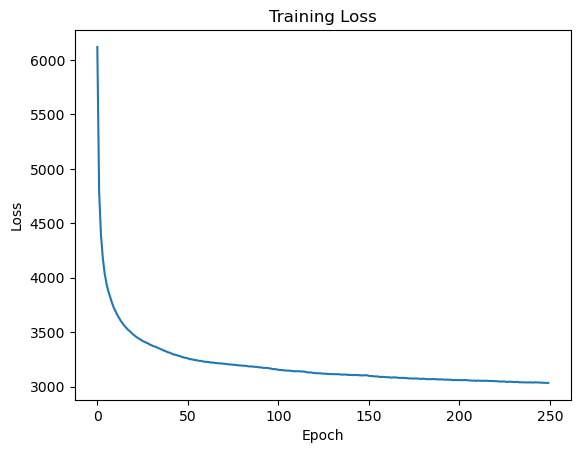


Classification Accuracy: 0.8117


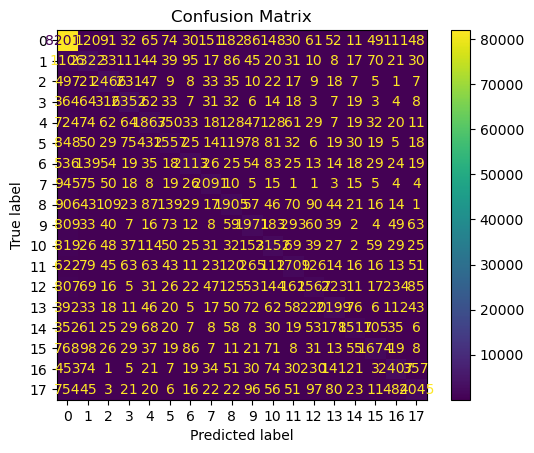


Per-Class Classification Summary:
 Class  Total Samples  Correctly Classified  Accuracy (%)
     0          83358                 82017         98.39
    13           4105                  2322         56.57
    14           3443                  2466         71.62
    15           3343                  2352         70.36
    16           3674                  1867         50.82
    17           3437                  1557         45.30
    18           3244                  2113         65.14
    19           3295                  2091         63.46
    20           3617                  1905         52.67
    21           3721                  1971         52.97
    22           3737                  2152         57.59
    23           3391                  1709         50.40
    24           3644                  1567         43.00
    25           3440                  2199         63.92
    26           2579                  1517         58.82
    27           2981                

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from dataloader import load_db, data_split_emg
from train_helpers import assess_model_nn

# Hyperparameters
SAMPLES_PER_CLASS = 5000
REDUCE = False
BATCH_SIZE = 128
EPOCHS = 250
LR = 1e-3
MODEL_DIR = './data/model_weights/'
FORCE_RETRAIN = False

# Paths
encoder_path = os.path.join(MODEL_DIR, 'encoderDB1_full_test.pth')
gesture_decoder_path = os.path.join(MODEL_DIR, 'gesture_decoder_full_test.pth')
recon_decoder_path = os.path.join(MODEL_DIR, 'recon_decoder_full_test.pth')

os.makedirs(MODEL_DIR, exist_ok=True)

# Load DB1 (Exercise B)
df_db = load_db(db=1, exercise='B', samples_per_class=SAMPLES_PER_CLASS, reduce=REDUCE)
X_train, X_test, y_train, y_test = data_split_emg(df_db, test_size=0.2)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
encoder = EncoderDB1()
gesture_decoder = GestureDecoder()
recon_decoder = ReconstructionDecoder()

# Load models if they exist
if all(os.path.exists(p) for p in [encoder_path, gesture_decoder_path, recon_decoder_path]) and not FORCE_RETRAIN:
    print("Loading model weights...")
    encoder.load_state_dict(torch.load(encoder_path))
    gesture_decoder.load_state_dict(torch.load(gesture_decoder_path))
    recon_decoder.load_state_dict(torch.load(recon_decoder_path))
else:
    print("Training new models...")
    losses = []
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(gesture_decoder.parameters()) + list(recon_decoder.parameters()),
        lr=LR
    )
    criterion_class = nn.CrossEntropyLoss()
    criterion_recon = nn.MSELoss()

    for epoch in range(EPOCHS):
        encoder.train()
        gesture_decoder.train()
        recon_decoder.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            z = encoder(X_batch)
            logits = gesture_decoder(z)
            recon = recon_decoder(z)

            loss_class = criterion_class(logits, y_batch)
            loss_recon = criterion_recon(recon, X_batch)
            loss = loss_class + loss_recon

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss)
        print(f"Epoch {epoch+1}/{EPOCHS} - Total Loss: {total_loss:.4f}")

    # Save models
    torch.save(encoder.state_dict(), encoder_path)
    torch.save(gesture_decoder.state_dict(), gesture_decoder_path)
    torch.save(recon_decoder.state_dict(), recon_decoder_path)

# Plot losses during training
if len(losses) > 0:
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Evaluate
assess_model_nn(encoder, gesture_decoder, recon_decoder, X_test, y_test)

## Training for Encoding of DB2 (using frozen Classifier)

Training new model...
Epoch 1/250 - Total Loss: 10113.4214
Epoch 2/250 - Total Loss: 9718.7754
Epoch 3/250 - Total Loss: 9616.4366
Epoch 4/250 - Total Loss: 9566.8404
Epoch 5/250 - Total Loss: 9538.2865
Epoch 6/250 - Total Loss: 9523.7902
Epoch 7/250 - Total Loss: 9514.6129
Epoch 8/250 - Total Loss: 9506.7621
Epoch 9/250 - Total Loss: 9499.6801
Epoch 10/250 - Total Loss: 9493.6318
Epoch 11/250 - Total Loss: 9490.3816
Epoch 12/250 - Total Loss: 9487.2020
Epoch 13/250 - Total Loss: 9485.7798
Epoch 14/250 - Total Loss: 9483.5353
Epoch 15/250 - Total Loss: 9481.4378
Epoch 16/250 - Total Loss: 9479.1376
Epoch 17/250 - Total Loss: 9477.1078
Epoch 18/250 - Total Loss: 9476.3304
Epoch 19/250 - Total Loss: 9471.0504
Epoch 20/250 - Total Loss: 9470.1281
Epoch 21/250 - Total Loss: 9465.5925
Epoch 22/250 - Total Loss: 9463.8155
Epoch 23/250 - Total Loss: 9461.7264
Epoch 24/250 - Total Loss: 9460.2156
Epoch 25/250 - Total Loss: 9459.0839
Epoch 26/250 - Total Loss: 9457.9601
Epoch 27/250 - Total Los

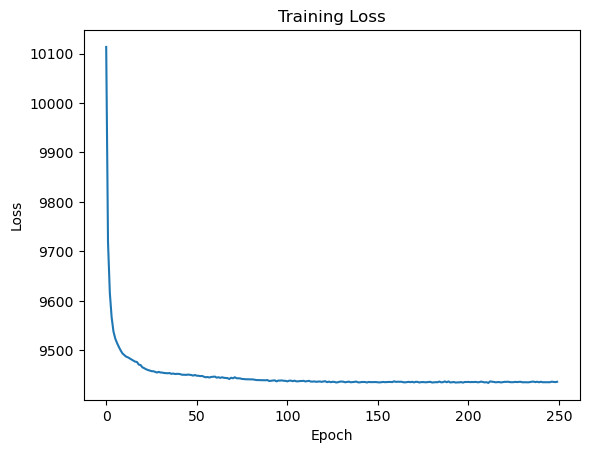


Classification Accuracy: 0.5531


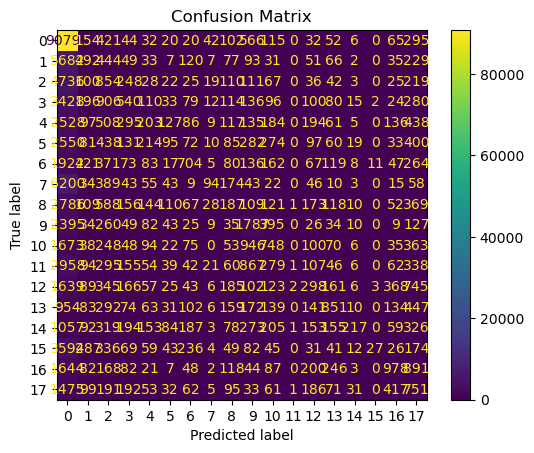


Per-Class Classification Summary:
 Class  Total Samples  Correctly Classified  Accuracy (%)
     0          92763                 90797         97.88
    13           7418                   492          6.63
    14           6645                   854         12.85
    15           6151                   540          8.78
    16           5123                   203          3.96
    17           4841                    95          1.96
    18           4490                   704         15.68
    19           7238                    94          1.30
    20           5128                   187          3.65
    21           5320                  1787         33.59
    22           4519                   748         16.55
    23           5424                     1          0.02
    24           4363                   298          6.83
    25           3658                   851         23.26
    26           3556                   217          6.10
    27           5115                

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from dataloader import load_db, data_split_emg
from train_helpers import assess_model_nn

# Hyperparameters
SAMPLES_PER_CLASS = 5000
REDUCE = False
BATCH_SIZE = 128
EPOCHS = 250
LR = 1e-3
MODEL_DIR = './data/model_weights/'
FORCE_RETRAIN = True

# Paths
encoder_path = os.path.join(MODEL_DIR, 'encoderDB2_full_test.pth')
gesture_decoder_path = os.path.join(MODEL_DIR, 'gesture_decoder_full_test.pth')

os.makedirs(MODEL_DIR, exist_ok=True)

# Load DB2 (Exercise B)
df_db = load_db(db=2, exercise='B', samples_per_class=SAMPLES_PER_CLASS, reduce=REDUCE)
X_train, X_test, y_train, y_test = data_split_emg(df_db, test_size=0.2)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
encoder = EncoderDB2()
gesture_decoder = GestureDecoder()

# Load trained decoder
try:
    gesture_decoder.load_state_dict(torch.load(gesture_decoder_path))
except FileNotFoundError:
    print("Gesture decoder not found. Please train it first.")
    exit()

# Freeze decoders
for param in gesture_decoder.parameters():
    param.requires_grad = False

# Load DB2 encoder if it exists
if os.path.exists("./data/model_weights/encoderDB2_full_test.pth") and not FORCE_RETRAIN:
    print("Loading model weights...")
    encoder.load_state_dict(torch.load(encoder_path))
else:
    print("Training new model...")
    losses = []
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    criterion_class = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        encoder.train()
        gesture_decoder.eval() # Freeze decoder
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            z = encoder(X_batch)
            logits = gesture_decoder(z)
            loss_class = criterion_class(logits, y_batch)
            loss_class.backward()
            optimizer.step()
            total_loss += loss_class.item()

        losses.append(total_loss)
        print(f"Epoch {epoch+1}/{EPOCHS} - Total Loss: {total_loss:.4f}")

    # Save model
    torch.save(encoder.state_dict(), encoder_path)

# Plot losses during training
if len(losses) > 0:
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Evaluate
assess_model_nn(encoder, gesture_decoder, recon_decoder=None, X_test=X_test, y_test=y_test)

## Translate DB2 samples to DB1

In [11]:
import pandas as pd
import torch
import os
from dataloader import load_db

# Load DB2 (Exercise C)
db_df = load_db(db=2, exercise='C', reduce=False)
emg_features = [col for col in db_df.columns if col.startswith('emg_')]
X = db_df[emg_features]
y = db_df['gesture'].astype(int)

# Convert X to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)

# Load trained models
MODEL_DIR = './data/model_weights/'
encoder_path = os.path.join(MODEL_DIR, 'encoderDB2_full_test.pth')
recon_decoder_path = os.path.join(MODEL_DIR, 'recon_decoder_full_test.pth')
encoder = EncoderDB2()
recon_decoder = ReconstructionDecoder()
encoder.load_state_dict(torch.load(encoder_path))
recon_decoder.load_state_dict(torch.load(recon_decoder_path))

# Translate to DB1
encoder.eval()
z = encoder(X_tensor)
recon = recon_decoder(z)

# Convert recon to dataframe
recon_df = pd.DataFrame(recon.detach().numpy(), columns=emg_features[:10])
recon_df['gesture'] = y

# Save to csv
recon_df.to_csv('./data/db2_to_db1_exC.csv', index=False)

## Retrain RF on DB1 with added translated data

In [ ]:
from train_helpers import assess_model_nn
import numpy as np
import pandas as pd
from dataloader import load_db, data_split_emg

# CONSTANTS
EPOCHS = 50
LR = 0.001
BATCH_SIZE = 128
MODEL_DIR = './data/model_weights/'

# Load DB1 (Exercise B)
df_db = load_db(db=1, exercise='B', reduce=False)
X_train, X_test, y_train, y_test = data_split_emg(df_db, test_size=0.2)

# Add translated DB2 (Exercise C) data to train set
translated_df = pd.read_csv('./data/db2_to_db1_exC.csv')
translated_emg = translated_df[translated_df.columns[:-1]].values
translated_labels = translated_df['gesture'].values
X_train = np.concatenate((X_train, translated_emg), axis=0)
y_train = np.concatenate((y_train, translated_labels), axis=0)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
encoder = EncoderDB1()
gesture_decoder = GestureDecoder()

# Load trained models
try:
    encoder_path = os.path.join(MODEL_DIR, 'encoderDB1_full_test.pth')
    gesture_decoder_path = os.path.join(MODEL_DIR, 'gesture_decoder_full_test.pth')
    gesture_decoder.load_state_dict(torch.load(gesture_decoder_path))
    encoder.load_state_dict(torch.load(encoder_path))
except FileNotFoundError:
    print("Trained models not found. Please train it first.")
    exit()


print("Training new model...")
losses = []
optimizer = optim.Adam(list(encoder.parameters()) + list(gesture_decoder.parameters()), lr=LR)
criterion_class = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    encoder.train()
    gesture_decoder.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        z = encoder(X_batch)
        logits = gesture_decoder(z)
        loss_class = criterion_class(logits, y_batch)
        loss_class.backward()
        optimizer.step()
        total_loss += loss_class.item()

    losses.append(total_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Total Loss: {total_loss:.4f}")

# Save model
torch.save(encoder.state_dict(), './data/model_weights/encoderDB1_full_translated.pth')
torch.save(gesture_decoder.state_dict(), './data/model_weights/gesture_decoder_full_translated.pth')

# Plot losses during training
if len(losses) > 0:
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Evaluate on test set (DB1 Exercise B)
assess_model_nn(encoder, gesture_decoder, recon_decoder=None, X_test=X_test, y_test=y_test)

In [ ]:
# Evaluate on unseen data (DB1 Exercise C)
df_db = load_db(db=1, exercise='C', reduce=False)
X = df_db[df_db.columns[:-1]].values
y = df_db['gesture'].values

assess_model_nn(encoder, gesture_decoder, recon_decoder=None, X_test=X, y_test=y)